# Single hidden layer

In [491]:
# backpropagation example for deep learning in python class.
# with sigmoid activation
#
# the notes for this class can be found at: 
# https://deeplearningcourses.com/c/data-science-deep-learning-in-python
# https://www.udemy.com/data-science-deep-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import numpy as np
import matplotlib.pyplot as plt


def create_data(Nclass, D, M, K):
    X1 = np.random.randn(Nclass, D) + np.array([0, -2])
    X2 = np.random.randn(Nclass, D) + np.array([2, 2])
    X3 = np.random.randn(Nclass, D) + np.array([-2, 2])
    X = np.vstack([X1, X2, X3])

    Y = np.array([0]*Nclass + [1]*Nclass + [2]*Nclass)

    # let's see what it looks like
    plt.scatter(X[:,0], X[:,1], c=Y, s=100, alpha=0.5)
    plt.show()
    
    return X, Y

def main():
    # create the data
    Nclass = 500
    D = 2 # dimensionality of input
    M = 3 # hidden layer size
    K = 3 # number of classes

    X, Y = create_data(Nclass, D, M, K)

    nn = SingleLayerNN(D, M, K)

    nn.fit(X, Y, 1000)
    
    preds, _ = nn.forward(X)
    
    return nn, preds, X, Y

In [606]:
class SingleLayerNN:
    
    def __init__(self, D, M, K, learning_rate=1e-3):
        """
        Simple feed forward neural network implemented with NumPy. Uses tanh as the activation function.

        Parameters
        ----------
        D : int
            Input dimension.
        M : int
            Hidden layer size.
        K : int
            Number of output classes.
        learning_rate : numeric
            Learning rate.
        """
        self.D = D
        self.M = M
        self.K = K
        self.learning_rate = learning_rate
        
        # randomly initialize weights
        self.W1 = np.random.randn(D, M)
        self.b1 = np.random.randn(M)
        self.W2 = np.random.randn(M, K)
        self.b2 = np.random.randn(K)
        
    def fit(self, X, Y, epochs=1000):
        """
        Fits the neural network using backpropagation.
        
        Parameters
        ----------
        X : numpy.ndarray, shape (N, D)
            Input matrix.
        Y : array-like, shape (N,)
            Vector of targets. This will be transformed into a onehot encoded indicator matrix, called T. 
        epochs : int
            Number of epochs.
            
        Returns
        -------
        None
        """
        K = self.K
        learning_rate = self.learning_rate
        W1 = self.W1
        b1 = self.b1
        W2 = self.W2
        b2 = self.b2
        
        T = self._to_indicator_matrix(Y, K)

        costs = []
        for epoch in range(epochs):
            output, hidden = self.forward(X)
            if epoch % (epochs / 10) == 0:
                c = self._cost(T, output)
                P = np.argmax(output, axis=1)
                r = self._classification_rate(Y, P)
                print("epoch:", epoch, "cost:", c, "classification_rate:", r)
                costs.append(c)

            # this is gradient ASCENT, not DESCENT
            # oldW2 = W2.copy()
            W2 += learning_rate * self._derivative_w2(hidden, T, output)
            b2 += learning_rate * self._derivative_b2(T, output)
            W1 += learning_rate * self._derivative_w1(X, hidden, T, output)
            b1 += learning_rate * self._derivative_b1(T, output, hidden)

        self.W2 = W2
        self.b2 = b2
        self.W1 = W1
        self.b1 = b1

        plt.plot(costs)
        plt.show()
        
        return None

    def forward(self, X):
        """
        Runs one forward pass of the neural network.
        
        Parameters
        ----------
        X : numpy.ndarray, shape(N, D)
            Input matrix.
        
        Returns
        -------
        tuple
            Y : np.ndarray, shape (N, K)
                Targets as indicator matrix.
            Z : np.ndarray, shape (N, M)
                Input into this hidden layer. This is either X or the output of the previous layer's activation nodes.
        """
        W1 = self.W1
        W2 = self.W2
        b1 = self.b1
        b2 = self.b2
        A0 = X.dot(W1) + b1
        Z = 1 / (1 + np.exp(-A0))  # Z: (N, M)
        A1 = Z.dot(W2) + b2  # A: Z: (N, M)
        expA = np.exp(A1)
        Y = expA / expA.sum(axis=1, keepdims=True)  # softmax, Y: (N, K)
        N = X.shape[0]
        assert Y.shape == (N, self.K)
        assert Z.shape == (N, self.M)
        return Y, Z
    
    def _to_indicator_matrix(self, x, n_distinct):
        """
        Turns a vector of integers into an indicator matrix.
        
        Parameters
        ----------
        x : array-like
            Vector of integers.
        n_distinct_values, int
            The number of distinct integers in the vector.
        
        Returns
        -------
        numpy.ndarray, shape (len(x), n_distinct) 
            Indicator matrix
        """
        n = len(x)
        X = np.zeros((n, n_distinct))
        for i in range(n):
            X[i, x[i]] = 1
        return X

    def _derivative_w2(self, Z, T, Y):
        """
        Computes partial derivative of loss function w.r.t weights from hidden layer to output.
        
        Parameters
        ----------
        Z : np.ndarray, shape (N, K)
            Output of hidden layer after activation nodes.
        T : np.ndarray, shape (N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape (N, K)
            Output as indicator matrix.
            
        Returns
        -------
        np.ndarray, shape (M, K)
            dJ/dW2 - partial derivative of cost w.r.t hidden to output weights.
        """
        N = len(T)
        assert Z.shape == (N, self.M)
        assert T.shape == (N, self.K)
        assert Y.shape == (N, self.K)
        M = Z.shape[1]  # H is (N, M)
        delta = T - Y
        prev_Z = Z
        ret = prev_Z.T.dot(delta)
        assert ret.shape == (self.M, self.K)
        return ret

    def _derivative_w1(self, X, Z, T, Y):
        """
        Computes partial derivative of loss function w.r.t weights from hidden X to hidden layer.
        
        Parameters
        ----------
        X : np.ndarray, shape (N, D)
            Input matrix.
        Z : np.ndarray, shape (N, M)
            Output of hidden layer after activation.
        T : np.ndarray, shape (N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape (N, K)
            Output as indicator matrix.
        
        Returns
        -------
        np.ndarray, shape (D, M)
            dJ/dW1 - partial derivatives of cost w.r.t. input to hidden layer weights.
        """
        W2 = self.W2
        N, D = X.shape
        M, K = W2.shape
        M = self.M
        assert X.shape == (N, D)
        assert Z.shape == (N, M)
        assert T.shape == (N, K)
        assert Y.shape == (N, K)
        subs_delta = (T - Y)
        dZ = Z * (1 - Z)
        delta = subs_delta.dot(W2.T) * dZ
        prev_Z = X
        ret2 = prev_Z.T.dot(delta)
        assert ret2.shape == (D, M)
        return ret2

    def _derivative_b2(self, T, Y):
        """
        Computes partial derivative of loss function w.r.t. bias weights feeding into output layer.
        
        Parameters
        ----------
        T : np.ndarray, shape (N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape (N, K)
            Output as indicator matrix.
        
        Returns
        -------
        np.array, shape (K,)
        """
        N = T.shape[0]
        K = self.K
        assert Y.shape == (N, K)
        ret = (T - Y).sum(axis=0)
        assert ret.shape == (K,)
        return ret

    def _derivative_b1(self, T, Y, Z):
        """
        Computes partial derivative of loss function w.r.t. bias weights feeding into output layer.
        
        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.narray, shape (N, K)
            Output as indicator matrix.
        Z : np.ndarray, shape (N, M)
            Output of hidden layer.
        
        Returns
        -------
        np.array, shape(M,)
        """
        W2 = self.W2
        M = self.M
        K = self.K
        N = T.shape[0]
        assert T.shape == (N, K)
        assert Y.shape == (N, K)
        assert Z.shape == (N, M)
        ret = ((T - Y).dot(W2.T) * Z * (1 - Z)).sum(axis=0)
        assert ret.shape == (M,)
        return ret

    def _cost(self, T, Y):
        """
        Computes the cost (error) of the predictions using T*log(Y).
        
        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.
        
        Returns
        -------
        float
            Total cost (error).
        """
        tot = T * np.log(Y)
        return tot.sum()
    
    def _classification_rate(self, Y, P):
        """
        Determines the classification rate, n_correct / n_total.
        
        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.
        
        Returns
        -------
        float
            n_correct / n_total
        """
        assert np.shape(Y) == np.shape(P)
        n_correct = 0
        n_total = 0
        for i in range(len(Y)):
            n_total += 1
            if Y[i] == P[i]:
                n_correct += 1
        return float(n_correct) / n_total

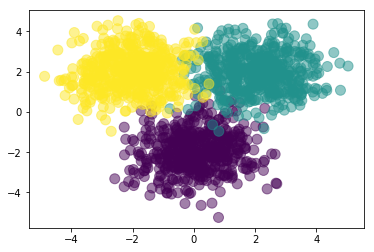

epoch: 0 cost: -5778.554436773446 classification_rate: 0.3333333333333333
epoch: 100 cost: -149.31774807751117 classification_rate: 0.9706666666666667
epoch: 200 cost: -130.23639445097365 classification_rate: 0.97
epoch: 300 cost: -122.39445290263754 classification_rate: 0.9726666666666667
epoch: 400 cost: -117.19626704998032 classification_rate: 0.972
epoch: 500 cost: -113.34911820767421 classification_rate: 0.972
epoch: 600 cost: -110.61095968800075 classification_rate: 0.9713333333333334
epoch: 700 cost: -108.70100116919346 classification_rate: 0.972
epoch: 800 cost: -107.34438946981453 classification_rate: 0.9726666666666667
epoch: 900 cost: -106.35539572016066 classification_rate: 0.9726666666666667


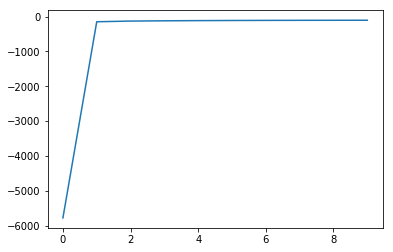

array([[9.96774387e-01, 3.13701619e-03, 8.85968046e-05],
       [9.97804366e-01, 1.15779076e-03, 1.03784346e-03],
       [9.97009101e-01, 2.68430438e-03, 3.06595055e-04],
       ...,
       [1.34633711e-03, 9.43284904e-04, 9.97710378e-01],
       [1.73065147e-03, 1.74840854e-03, 9.96520940e-01],
       [4.39167215e-04, 1.36871008e-03, 9.98192123e-01]])

In [607]:
_nn, _preds, _X, _Y = main()
_preds

# Multiple hidden layers

In [223]:
import numpy as np
import matplotlib.pyplot as plt


class Activation:
    
    def __init__(self):
        """
        Activation function used in a MLP neural network.
        """
        pass
    
    def forward(self, A):
        """
        Computes forward activation function.
        """
        raise NotImplementedError()
        
    def back(self, X):
        """
        Computes derivative of loss function activation function w.r.t.
        activation function for a particular layer.
        """
        raise NotImplementedError()
        
        
class Sigmoid(Activation):
    
    def __init__(self):
        """
        Sigmoid activation function used in a MLP neural network.
        """
        pass
        
    def forward(self, A):
        """
        Computes activation of a single layer.

        Parameters
        ----------
        A : np.ndarray, shape (N, M[i])
            Input into activation func. at layer i: (Z.dot(W)+b).

        Returns
        -------
        np.ndarray, shape (N, M[i])
        """
        _Z = 1 / (1 + np.exp(-A))
        return _Z
        
    def back(self, _Z):
        """
        Computes partial derivative of loss function w.r.t. activation
        function for a particular layer.

        Parameters
        ----------
        Z : np.ndarray, shape(N, M[i])
            Output of layer i.

        Returns
        -------
        np.ndarray, shape(N, M[i])
            Partial derivative of loss function w.r.t. activation function
            at layer i.
        """
        dZ = _Z*(1-_Z)
        return dZ
    
        
class ReLU(Activation):
    
    def __init__(self):
        """
        ReLU activation function used in a MLP neural network.
        """
        pass
        
    def forward(self, A):
        """
        Computes activation of a single layer.

        Parameters
        ----------
        A : np.ndarray, shape (N, M[i])
            Input into activation func. at layer i: (Z.dot(W)+b).

        Returns
        -------
        np.ndarray, shape (N, M[i])
        """
        _Z = A * (A > .5)
        assert not np.any(np.isnan(_Z))
        return _Z
        
    def back(self, _Z):
        """
        Computes partial derivative of loss function w.r.t. activation
        function for a particular layer.

        Parameters
        ----------
        Z : np.ndarray, shape(N, M[i])
            Output of layer i.

        Returns
        -------
        np.ndarray, shape(N, M[i])
            Partial derivative of loss function w.r.t. activation function
            at layer i.
        """
        dZ = np.piecewise(_Z, [_Z < .5, _Z >= .5], [0, 1])
        return dZ
    
        
class MLP:

    def __init__(self, D, hidden_layer_sizes, K, Z, learning_rate=1e-5, reg=.01):
        """
        Multip Layer Perceptron neural network implemented with NumPy. Uses gradient ascent.

        Parameters
        ----------
        D : int
            Input dimension.
        hidden_layer_sizes : array-like
            Hidden layer sizes. An array of integers.
        K : int
            Number of output classes.
        Z : Activation
            Activation function.
        learning_rate : numeric
            Learning rate.
        reg : numeric, default .01
            Regularization parameter.

        Attributes
        ----------
        n_layers, int
            Number of hidden layers, defined by length of hidden_layer_sizes.
        M : list, length (n_layers+2)
            Hidden layer sizes, with M[0] set to D and M[-1] set to K. This
            makes computing
            recursive forward and back propagation easier.
        W : numpy.array, shape (len(M)+1)
            Array of weight matrices.
        b : numpy.array, shape (len(M)+1)
            Array of bias matrices.

        Examples
        --------
        >>> D = X_train.shape[1]
        >>> K = Y_train.shape[0]
        >>> hidden_layer_sizes = [5, 5]
        >>> Z = Sigmoid()
        >>> model = FeedForward(D, hidden_layer_sizes, K, Z)
        >>> model.fit(X_train, Y_train)
        >>> preds, _ = model.forward(X_test)
        """
        self.D = D
        self.K = K
        self.Z = Z
        self.learning_rate = learning_rate
        self.reg = reg
        self.n_layers_ = len(hidden_layer_sizes)
        self.M = [D] + hidden_layer_sizes + [K]
        n_layers = self.n_layers_
        M = self.M
        self.W = [None for i in range(n_layers+1)]
        self.b = [None for i in range(n_layers+1)]

        # randomly initialize weights
        for i in range(n_layers+1):
            self.W[i] = np.random.randn(M[i], M[i+1])
            self.b[i] = np.random.randn(M[i+1])

    def forward(self, X):
        """
        Runs one forward pass through all layers. Final layer inputs are normalized
        prior to passing through softmax.

        Parameters
        ----------
        X : np.ndarray, shape (N, D)
            Input matrix.

        Returns
        -------
        Y : np.ndarray, shape(N, K)
            Outputs as indicator matrix.
        Z : list, shape (n_layers+1)
            Z values indexed by layer. Used for backpropagation. Note that Z[0]
            is X and Z[-1] is Y.
        """
        n_layers = self.n_layers_
        W = self.W
        b = self.b
        K = self.K
        N = X.shape[0]

        # Collect Z at each layer so we can use them in backprop.
        Z = [None for i in range(n_layers+2)]
        Z[0] = X.copy()
        
        for i in range(1, self.n_layers_+1):
            Z[i] = self._forward_single_layer(Z[i-1], i)
            assert not np.any(np.isnan(Z[i]))

        final_A = Z[-2].dot(W[n_layers]) + b[n_layers]
        assert not np.any(np.isnan(final_A))
        
        # Compute final layer outputs
        Y = self._forward_final_layer(final_A)
                    
        Z[-1] = Y
        assert len(Z) == n_layers + 2
        assert not np.any(np.isnan(Z[-1]))
        
        return Y, Z

    def fit(self, X, Y, epochs=1000, batch_size=1000):
        """
        Fits the neural network using backpropagation.

        Parameters
        ----------
        X : numpy.ndarray, shape (N, D)
            Input matrix.
        Y : array-like, shape (N,)
            Vector of targets. This will be transformed into a onehot encoded
            indicator matrix, called T.
        batch_size : int, default=1000
            Training batch size. If batch_size > len(X), then the batch size will be changed to len(X).
        epochs : int
            Number of epochs.

        Returns
        -------
        None
        """
        n_layers = self.n_layers_
        K = self.K
        learning_rate = self.learning_rate
        reg = self.reg

        T = self._transform_targets(Y)

        if batch_size > len(X):
            print('WARNING: Batch size > len(X). Setting batch size to len(X)')
            batch_size = len(X)
        n_batches = int(len(X) / batch_size)
        losses = []
        performance_metrics = []
        
        for epoch in range(epochs):
            _Output = np.empty_like(T)  #  Aggregate Output for entire epoch
            
            for b in range(n_batches):
                lower_idx = b*batch_size
                upper_idx = (b+1)*batch_size
                if upper_idx > len(X):
                    upper_idx = len(X) - 1
                X_batch = X[lower_idx:upper_idx, :]
                Output, _Z = self.forward(X_batch)
                _Output[lower_idx:upper_idx] = Output
                
                # this is gradient ASCENT, not DESCENT
                Delta = [None for i in range(n_layers+1)]
                for i in range(n_layers, -1, -1):  # Iterate backwards
                    W = self.W
                    b = self.b

                    if i == n_layers:
                        Delta[i] = self._backprop_delta_final_layer(T[lower_idx:upper_idx, :], Output)
                    else:
                        Delta[i] = self._backprop_delta(Delta[i+1], W[i+1], _Z[i+1],
                                                        i)

                    dJdW_i = self._dJdW(_Z[i], Delta[i], i)
                    dJdb_i = self._dJdb(Delta[i], i)

                    W[i] -= learning_rate * dJdW_i + reg*W[i]
                    b[i] -= learning_rate * dJdb_i + reg*b[i]

                    self.W = W
                    self.b = b
            if epoch % (epochs / 5) == 0:
                l = self._loss(T, _Output)
                P = self._transform_output(Output)
                pm = self._performance_metric(Y, P)
                print("epoch:", epoch, "loss:", l, "performance_metric:", pm)
                losses.append(l)
                performance_metrics.append(pm)

        fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13, 5))
        ax0.plot(losses[1:])
        ax0.set_title('Loss')
        ax1.plot(performance_metrics[1:])
        ax1.set_title('Performance Metric')
        plt.show()

        return None
    
    def predict(self, X):
        """
        Wrapper method around forward() and _transform_output. This method allows
        MLPs to conform to scikit-learn's fit/predict schema.
        
        Parameters
        ----------
        X : np.ndarray, shape (N, D)
            Input matrix.
            
        Returns
        -------
        ?
            Whatever `transformed_output()` returns.
        """
        Output = self.forward(X)
        transformed_Output = self._transform_output(Output)
        return transformed_Output

    def _forward_single_layer(self, prev_Z, i):
        """
        Runs one forward pass through a single layer.

        Parameters
        ----------
        prev_Z : numpy.ndarray, shape(N, M[i-1])
            Output of layer i-1.
        i : int
            Index of layer.

        Returns
        -------
        tuple
            Y : np.ndarray, shape (N, M[i])
                Output of layer i.
        """
        N = len(prev_Z)
        M = self.M
        W = self.W
        b = self.b
        Z = self.Z
        assert prev_Z.shape == (N, M[i-1])
        A = prev_Z.dot(W[i-1]) + b[i-1]
        assert A.shape == (N, M[i])
        _Z = Z.forward(A)
        assert _Z.shape == (N, M[i])
        assert not np.any(np.isnan(_Z))
        return _Z
    
    def _forward_final_layer(self, final_A):
        """
        Abstract method. Computes the forward pass of the final layer. This is different between
        classifcation and regression.
        
        Parameters
        ----------
        final_A, np.ndarray, shape (N, K)
            Final layer Wz+b
        
        Returns
        -------
        np.ndarray, shape (N, K)
            Final layer outputs.
        """
        raise NotImplementedError()

    def _transform_output(self, Output):
        """
        Abstract method. Transforms final layer output into predictions.
        
        Parameters
        ----------
        np.ndarray, shape (N, K)
        
        Returns
        -------
        ?
            Implementation-specific
        """
        raise NotImplementedError()
            
    def _transform_targets(self, Y):
        """
        Abstract method. Transforms targets, differs b/w regression and classification.
        
        Parameters
        ----------
        Y : array-like, shape(N)
        
        Returns
        -------
        ?
            Transformed targets. Implementation is specific to MLP type.
        """
        raise NotImplementedError()
        
    def _to_indicator_matrix(self, x, n_distinct):
        """
        Turns a vector of integers into an indicator matrix.

        Parameters
        ----------
        x : array-like
            Vector of integers.
        n_distinct_values, int
            The number of distinct integers in the vector.

        Returns
        -------
        numpy.ndarray, shape (len(x), n_distinct)
            Indicator matrix
        """
        n = len(x)
        X = np.zeros((n, n_distinct))
        for i in range(n):
            X[i, x[i]] = 1
        return X

    def _loss(self, T, Y):
        """
        Abstract method. Computes the loss of the predictions.

        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.

        Returns
        -------
        float
            Total loss.
        """
        raise NotImplementedError()
        
    def _performance_metric(self, Y, P):
        """
        Abstract method. Computes performance metric.

        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.

        Returns
        -------
        float
            ?
        """
        raise NotImplementedError()
    
    def _backprop_delta_final_layer(self, T, Output):
        """
        Abstract method. Compute the backprop delta for the final layer. This is different for regression and
        classification, since classification uses softmax.
        
        Parameters
        ----------
        T : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch targets as indicator matrix.
        Output : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch output.

        Returns
        -------
        np.ndarray, shape (N, K)
            Delta of final layer.
        """
        raise NotImplementedError()
    
    def _backprop_delta(self, subs_Delta, subs_W, _Z, i):
        """
        Computes the delta for computing weight update.

        Parameters
        ----------
        subs_Delta : np.ndarray, shape (N, M[i+2])
            Delta at subsequent layer (i+1).
        subs_W : np.ndarray, shape (M[i+1], M[i+2])
            Weights at subsequent layer (i+1).
        _Z : np.ndarray, shape (N, M[i+1])
            Layer outputs at current layer. Note that _Z[i] comes BEFORE W[i],
            since we set _Z[0] to X. Therefore, the Z index for the ith layer is
            Z[i+1].
        i : int
            Index of hidden layer.

        Returns
        -------
        np.ndarray, shape (N, M[i+1])
            Delta of layer i.
        """
        M = self.M
        N = len(_Z)
        Z = self.Z
        assert subs_Delta.shape == (N, M[i+2])
        assert subs_W.shape == (M[i+1], M[i+2])
        assert _Z.shape == (N, M[i+1])
        dJdZ = Z.back(_Z)
        ret = (subs_Delta.dot(subs_W.T))*dJdZ
        assert ret.shape == (N, M[i+1])
        return ret

    def _dJdW(self, prev_Z, Delta, i):
        """
        Computes partial derivative of loss function w.r.t. weights at layer i.

        Parameters
        ----------
        prev_Z : np.ndarray, shape (N, M[i])
            Output of previous layer.
        Delta : np.ndarray, shape(N, M[i+1])
            Delta of current layer.
        i : int
            Hidden layer index.

        Returns
        -------
        np.ndarray, shape(M[i], M[i+1])
            Partial derivatives of loss function w.r.t. weights at layer i.
        """
        M = self.M
        N = len(prev_Z)
        assert prev_Z.shape == (N, M[i])
        assert Delta.shape == (N, M[i+1])
        ret = prev_Z.T.dot(Delta)
        assert ret.shape == (M[i], M[i+1])
        return ret

    def _dJdb(self, Delta, i):
        """
        Computes partial derivative of loss function w.r.t. biases at layer i.

        Parameters
        ----------
        Delta : np.ndarray, shape(N, M[i+1])
            Delta of current layer.
        i : int
            Hidden layer index.

        Returns
        -------
        np.ndarray, shape(M[i+1])
            Partial derivatives of loss function w.r.t. biases at layer i.
        """
        M = self.M
        N = Delta.shape[0]
        assert Delta.shape == (N, M[i+1])
        ret = np.sum(Delta, axis=0)
        assert ret.shape == (M[i+1],)
        return ret

In [224]:
class MLPClassifier(MLP):
    
    def _transform_targets(self, Y):
        """
        Transforms targets into indicator matrix.
        
        Parameters
        ----------
        Y : array-like, shape(N)
        
        Returns
        -------
        np.ndarray, shape(N, K)
            Transformed targets as indicator matrix.
        """
        K = self.K
        return self._to_indicator_matrix(Y, K)
    
    def _forward_final_layer(self, final_A):
        """
        Computes the forward pass of the final layer. For classificaiton, this normalizes the
        inputs and computes softmax.
        
        Parameters
        ----------
        final_A, np.ndarray, shape (N, K)
            Final layer Wz+b
        
        Returns
        -------
        np.ndarray, shape (N, K)
            Final layer outputs.
        """
        K = self.K
        N = final_A.shape[0]
        
        # Normalize inputs
        final_A_mean = np.stack((final_A.mean(axis=1),) * K, axis=-1)
        final_A_std = np.stack((final_A.std(axis=1),) * K, axis=-1)
        final_A = (final_A - final_A_mean) / final_A_std
        
        # Compute softmax
        expA = np.exp(final_A)
        assert not np.any(np.isnan(expA))
        Y = expA / expA.sum(axis=1, keepdims=True)
        assert Y.shape == (N, K)
        assert not np.any(np.isnan(Y))
        
        return Y
    
    def _transform_output(self, Output):
        """
        Transforms final layer output into predictions, which are an array of predicted classes.
        
        Parameters
        ----------
        np.ndarray, shape (N, K)
        
        Returns
        -------
        np.ndarray, shape (N,)
            Array of predicted classes.
        """
        P = np.argmax(_Output, axis=1)
        return P
    
    def _loss(self, T, Y):
        """
        Computes the loss of the predictions using T*log(Y).

        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.

        Returns
        -------
        float
            Total cost (error).
        """
        loss = -T*np.log(Y)
        loss = loss.sum()
        assert not np.any(np.isnan(loss))
        return loss
    
    def _performance_metric(self, Y, P):
        """
        Determines the classification rate, n_correct / n_total.

        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.

        Returns
        -------
        float
            n_correct / n_total
        """
        assert np.shape(Y) == np.shape(P)
        n_correct = 0
        n_total = 0
        for i in range(len(Y)):
            n_total += 1
            if Y[i] == P[i]:
                n_correct += 1
        return float(n_correct) / n_total
    
    def _backprop_delta_final_layer(self, T, Output):
        """
        Compute the backprop delta for the final layer. For classification, this factors in
        the softmax derivative.
        
        Parameters
        ----------
        T : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch targets as indicator matrix.
        Output : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch output.

        Returns
        -------
        np.ndarray, shape (N, K)
            Delta of final layer.
        """
        return -1*(T - Output)

In [225]:
from sklearn.metrics import r2_score

class MLPRegressor(MLP):
    
    def _transform_targets(self, Y):
        """
        Returns targets as is.
        
        Parameters
        ----------
        Y : array-like, shape(N)
        
        Returns
        -------
        array-like, shape (N)
            Targets as is.
        """
        return Y
    
    def _forward_final_layer(self, final_A):
        """
        Computes the forward pass of the final layer. For regression, this is just the final Wz+b.
        
        Parameters
        ----------
        final_A, np.ndarray, shape (N, K)
            Final layer Wz+b
        
        Returns
        -------
        np.ndarray, shape (N, K)
            Final layer outputs.
        """
        return final_A
    
    def _transform_output(self, Output):
        """
        Returns Output as is.
        
        Parameters
        ----------
        np.ndarray, shape (N, K)
        
        Returns
        -------
        np.array, shape (N,)
            Array of Outputs.
        """
        return Output
    
    def _loss(self, T, Y):
        """
        Computes the loss of the predictions using MSE. Note that this is actually the reward since we're doing gradient ascent.

        Parameters
        ----------
        T : np.ndarray, shape(N, K)
            Targets as indicator matrix.
        Y : np.ndarray, shape(N, K)
            Predictions as indicator matrix.

        Returns
        -------
        float
            Total loss.
        """
        loss = .5*((T-Y)**2).mean()
        assert not np.any(np.isnan(loss))
        return loss
    
    def _performance_metric(self, Y, P):
        """
        Computes r2.

        Parameters
        ----------
        Y : array-like, shape (N,)
            Targets.
        P : array-like, shape (N,)
            Predictions.

        Returns
        -------
        float
            r2
        """
#         Y_mean = Y.mean()
#         ssreg = ((P - Y_mean)**2).sum()
#         sstot = ((Y - Y_mean)**2).sum()
#         r2 = ssreg / sstot
#         return r2
        return r2_score(Y, P)
        
    def _backprop_delta_final_layer(self, T, Output):
        """
        Compute the backprop delta for the final layer. For regression, this is
        just dJ/dY, where J is MSE, or `.5*((T-Y)**2).mean()`.
        
        Parameters
        ----------
        T : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch targets as indicator matrix.
        Output : np.ndarray, shape (N[lower_idx:upper_idx], K)
            Batch output.

        Returns
        -------
        np.ndarray, shape (N, K)
            Delta of final layer.
        """
        return -1*(T-Output)

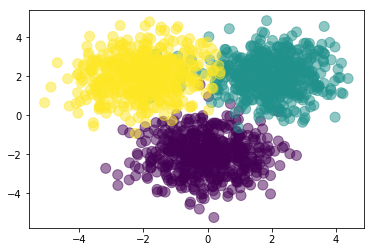

epoch: 0 cost: -25063.007442228965 classification_rate: 0.33666666666666667
epoch: 100 cost: -174.3132312949224 classification_rate: 0.97
epoch: 200 cost: -147.15617368946758 classification_rate: 0.9733333333333334


KeyboardInterrupt: 

In [1287]:
# create the data
# NOTE: N = Nclass * K

np.random.seed(123)

_Nclass = 500
_D = 2 # dimensionality of input
_M = [50] # hidden layer sizes
_K = 3 # number of classes

_X, _Y = create_data(_Nclass, _D, _M, _K)

_nn = MLP(_D, _M, _K, ReLU(), learning_rate=1e-5)

_nn.fit(_X, _Y, 500, batch_size=15)

_preds, _Z = _nn.forward(_X)

In [76]:
# create the data
# NOTE: N = Nclass * K

np.random.seed(123)

_Nclass = 500
_D = 2 # dimensionality of input
_M = [50] # hidden layer sizes
_K = 3 # number of classes

_X, _Y = create_data(_Nclass, _D, _M, _K)

_nn = MLP(_D, _M, _K, ReLU(), learning_rate=1e-5)

_nn.fit(_X, _Y, 500, batch_size=15)

_preds, _Z = _nn.forward(_X)

NameError: name 'create_data' is not defined

# MNIST

In [939]:
# import pandas as pd


# mnist_train = pd.read_csv('./data/mnist-in-csv/mnist_train.csv')
# mnist_test = pd.read_csv('./data/mnist-in-csv/mnist_test.csv')

X_train = mnist_train.loc[:, mnist_train.columns != 'label'].values[0:60000]
y_train = mnist_train['label'].values[0:60000]

X_test = mnist_train.loc[:, mnist_test.columns != 'label'].values[0:10000]
y_test = mnist_test['label'].values[0:10000]

In [940]:
np.random.seed(123)

model = FeedForward(D=784, hidden_layer_sizes=[800, 10],
                    K=10, Z=ReLU(), learning_rate=1e-5)

model.fit(X_train, y_train, 10)

preds, Z = model.forward(X_test)
digit_preds = np.argmax(preds, axis=1)
test_acc = len(np.where(digit_preds == y_test)[0])/len(y_test)
print('Test accuracy: {:.3f}'.format(test_acc))

/Users/jblandin/miniconda3/envs/rlpomdp/lib/python3.6/site-packages/ipykernel_launcher.py:202: RuntimeWarning: invalid value encountered in true_divide
/Users/jblandin/miniconda3/envs/rlpomdp/lib/python3.6/site-packages/ipykernel_launcher.py:336: RuntimeWarning: divide by zero encountered in log
/Users/jblandin/miniconda3/envs/rlpomdp/lib/python3.6/site-packages/ipykernel_launcher.py:336: RuntimeWarning: invalid value encountered in multiply


epoch: 0 cost: nan classification_rate: 0.09868333333333333


KeyboardInterrupt: 

# Iris Setosa

In [1006]:
from sklearn.model_selection import train_test_split


iris = pd.read_csv('./data/iris-setosa.csv')
iris['species'] = pd.Categorical(iris.species)
iris['target'] = iris['species'].cat.codes
iris_train, iris_test = train_test_split(iris, test_size=.33)
X_train = iris_train[['sepal_length', 'sepal_width',
                      'petal_length', 'petal_width']].values
y_train = iris_train['target'].values
X_test = iris_test[['sepal_length', 'sepal_width',
                    'petal_length', 'petal_width']].values
y_test = iris_test['target'].values

epoch: 0 cost: -615.0430616652943 classification_rate: 0.37
epoch: 500 cost: -42.7880321552093 classification_rate: 0.65
epoch: 1000 cost: -7.985151080236383 classification_rate: 0.98
epoch: 1500 cost: -7.085598012529072 classification_rate: 0.99
epoch: 2000 cost: -6.726031593993076 classification_rate: 0.99
epoch: 2500 cost: -6.513626902796991 classification_rate: 0.99
epoch: 3000 cost: -6.356720838297983 classification_rate: 0.99
epoch: 3500 cost: -6.233342180963495 classification_rate: 0.99
epoch: 4000 cost: -6.133570474807998 classification_rate: 0.99
epoch: 4500 cost: -6.046613341146972 classification_rate: 0.99


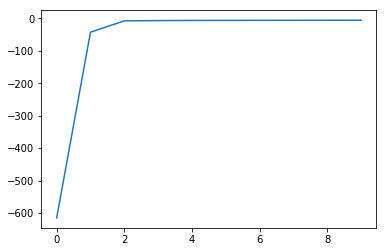

Test accuracy: 0.960


In [1010]:
np.random.seed(123)

model = FeedForward(D=4, hidden_layer_sizes=[4, 4], K=3,
                    Z=RelU(), learning_rate=1e-4)

model.fit(X_train, y_train, 5000)

preds, Z = model.forward(X_test)
digit_preds = np.argmax(preds, axis=1)
test_acc = len(np.where(digit_preds == y_test)[0])/len(y_test)
print('Test accuracy: {:.3f}'.format(test_acc))

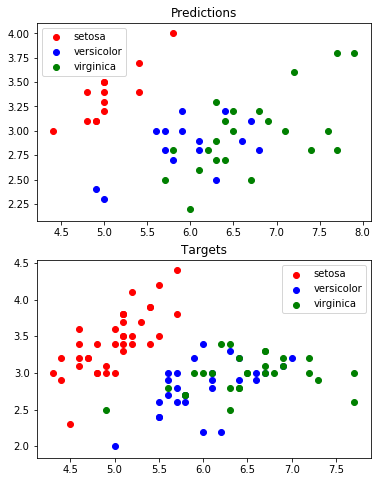

In [1011]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6,8))

iris_test0 = iris_test.query('target == 0')
iris_test1 = iris_test.query('target == 1')
iris_test2 = iris_test.query('target == 2')

ax0.scatter(iris_test0['sepal_length'], iris_test0['sepal_width'], label='setosa', c='r')
ax0.scatter(iris_test1['sepal_length'], iris_test1['sepal_width'], label='versicolor', c='b')
ax0.scatter(iris_test2['sepal_length'], iris_test2['sepal_width'], label='virginica', c='g')
ax0.set_title('Predictions')
ax0.legend()

iris_train0 = iris_train.query('target == 0')
iris_traain1 = iris_train.query('target == 1')
iris_train2 = iris_train.query('target == 2')

ax1.set_title('Targets')
ax1.scatter(iris_train0['sepal_length'], iris_train0['sepal_width'], label='setosa', c='r')
ax1.scatter(iris_train1['sepal_length'], iris_train1['sepal_width'], label='versicolor', c='b')
ax1.scatter(iris_train2['sepal_length'], iris_train2['sepal_width'], label='virginica', c='g')
ax1.legend()

# Spiral

## Source code for plotting predictions during training

In [227]:
import numpy as np
import matplotlib.pyplot as plt

        
class SpiralMLP(MLPClassifier):

    def fit(self, X, Y, epochs=50000, batch_size=100):
        """
        Fits the neural network using backpropagation.

        Parameters
        ----------
        X : numpy.ndarray, shape (N, D)
            Input matrix.
        Y : array-like, shape (N,)
            Vector of targets. This will be transformed into a onehot encoded
            indicator matrix, called T.
        batch_size : int, default=1000
            Training batch size. If batch_size > len(X), then the batch size will be changed to len(X).
        epochs : int
            Number of epochs.

        Returns
        -------
        None
        """
        n_layers = self.n_layers_
        K = self.K
        learning_rate = self.learning_rate
        reg = self.reg

        T = self._transform_targets(Y)

        if batch_size > len(X):
            print('WARNING: Batch size > len(X). Setting batch size to len(X)')
            batch_size = len(X)
        n_batches = int(len(X) / batch_size) + 1
        losses = []
        performance_metrics = []
        
        for epoch in range(epochs):
            _Output = np.zeros_like(T)  #  Aggregate Output for entire epoch
            
            for b in range(n_batches):
                lower_idx = b*batch_size
                upper_idx = (b+1)*batch_size
                if upper_idx > len(X):
                    upper_idx = len(X)
                X_batch = X[lower_idx:upper_idx, :]
                Output, _Z = self.forward(X_batch)
                _Output[lower_idx:upper_idx] = Output
                
                # this is gradient ASCENT, not DESCENT
                Delta = [None for i in range(n_layers+1)]
                for i in range(n_layers, -1, -1):  # Iterate backwards
                    W = self.W
                    b = self.b

                    if i == n_layers:
                        Delta[i] = self._backprop_delta_final_layer(T[lower_idx:upper_idx, :], Output)
                    else:
                        Delta[i] = self._backprop_delta(Delta[i+1], W[i+1], _Z[i+1],
                                                        i)

                    dJdW_i = self._dJdW(_Z[i], Delta[i], i)
                    dJdb_i = self._dJdb(Delta[i], i)

                    W[i] -= learning_rate * dJdW_i + reg*W[i]
                    b[i] -= learning_rate * dJdb_i + reg*b[i]

                    self.W = W
                    self.b = b
            if epoch % (epochs / 5) == 0:
                l = self._loss(T, _Output)
                P = np.argmax(_Output, axis=1)
                pm = self._performance_metric(Y, P)
                print("epoch:", epoch, "loss:", l, "performance_metric:", pm)
                losses.append(l)
                performance_metrics.append(pm)
                # Plot predictions
                digit_preds = np.argmax(_Output, axis=1)
                t1_idx = np.where(Y == 0)
                t2_idx = np.where(Y == 1)
                t3_idx = np.where(Y == 2)
                p1_idx = np.where(digit_preds == 0)
                p2_idx = np.where(digit_preds == 1)
                p3_idx = np.where(digit_preds == 2)
                t1 = X[t1_idx]
                t2 = X[t2_idx]
                t3 = X[t3_idx]
                p1 = X[p1_idx]
                p2 = X[p2_idx]
                p3 = X[p3_idx]
                fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,5))
                ax0.scatter(t1[:, 0], t1[:, 1], c='r', label='0')
                ax0.scatter(t2[:, 0], t2[:, 1], c='b', label='1')
                ax0.scatter(t3[:, 0], t3[:, 1], c='g', label='2')
                ax1.scatter(p1[:, 0], p1[:, 1], c='r', label='0')
                ax1.scatter(p2[:, 0], p2[:, 1], c='b', label='1')
                ax1.scatter(p3[:, 0], p3[:, 1], c='g', label='2')
                ax0.set_title('Targets')
                ax1.set_title('Predictions')
                ax1.legend()
                plt.show(block=False)

        for i, loss in enumerate(losses):
            print("epoch:", (i+1)*(epochs/5),
                  "cost:", loss,
                  "performance_metric:", performance_metrics[i])
            
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax.plot(losses[1:])
        ax.set_title('Loss')
        plt.show()

        return None

## Train

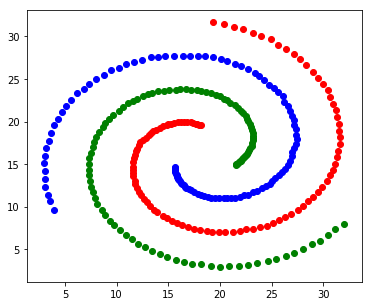

In [193]:
spiral = pd.read_csv('./data/spiral.csv')

fig, ax = plt.subplots(1, 1, figsize=(6,5))

s1 = spiral.query('target == 1')
s2 = spiral.query('target == 2')
s3 = spiral.query('target == 3')

ax.scatter(s1.x, s1.y, c='r')
ax.scatter(s2.x, s2.y, c='b')
ax.scatter(s3.x, s3.y, c='g')


from sklearn.model_selection import train_test_split

spiral = pd.read_csv('./data/spiral.csv')
# Targets are indexed starting at 1, which messes up to_indicator_matrix
spiral['target'] = spiral['target'] - 1


# Normalize values (otherwise )
spiral['x_norm'] = (spiral['x'] - spiral['x'].mean()) / spiral['x'].std()
spiral['y_norm'] = (spiral['y'] - spiral['y'].mean()) / spiral['y'].std()

spiral_train, spiral_test = train_test_split(spiral, test_size=.33)
X_train = spiral_train[['x_norm', 'y_norm']].values
y_train = spiral_train['target'].values
X_test = spiral_test[['x_norm', 'y_norm']].values
y_test = spiral_test['target'].values

epoch: 0 loss: 312.3220723795083 performance_metric: 0.3014354066985646


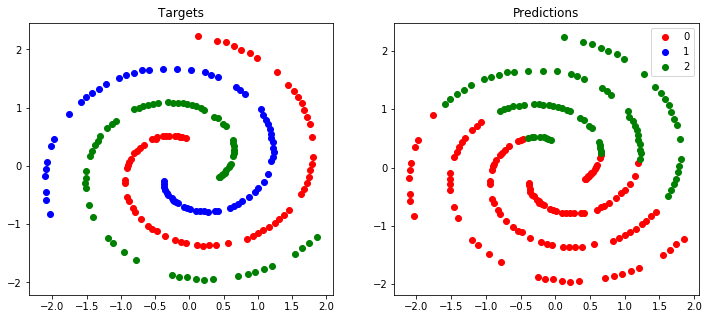

epoch: 200 loss: 318.03888454781224 performance_metric: 0.3444976076555024


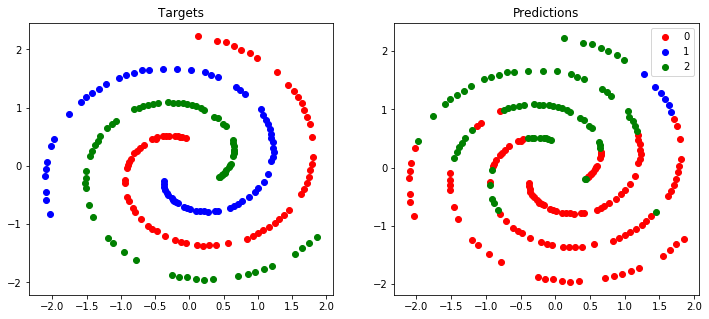

epoch: 400 loss: 279.0885957082136 performance_metric: 0.4019138755980861


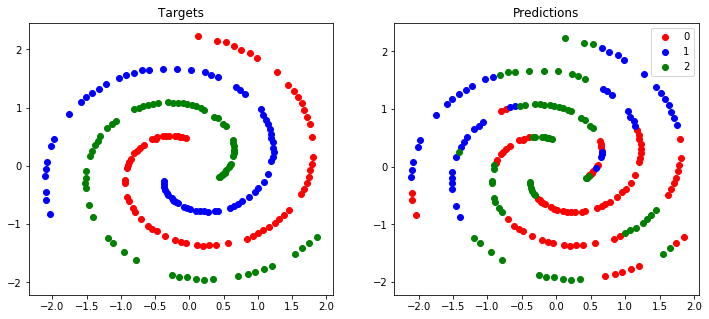

epoch: 600 loss: 272.8813577514776 performance_metric: 0.3923444976076555


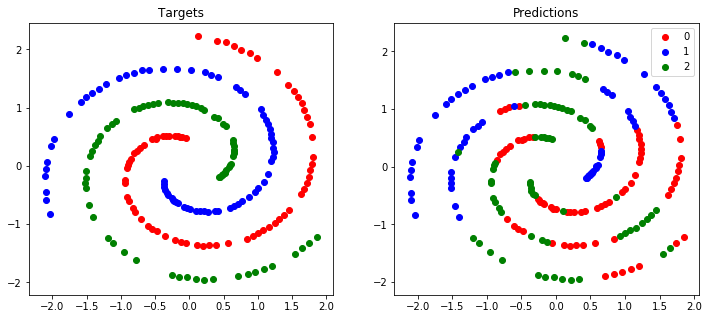

epoch: 800 loss: 240.3828822745495 performance_metric: 0.4688995215311005


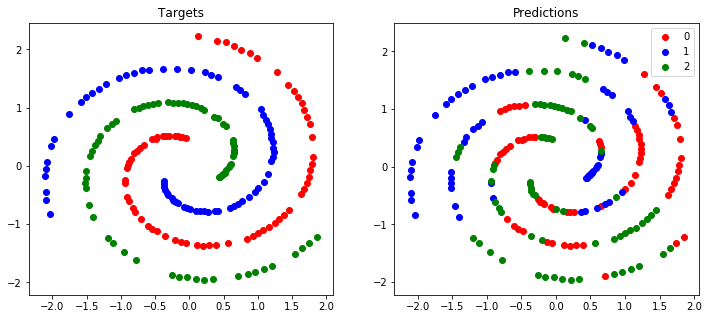

epoch: 200.0 cost: 312.3220723795083 performance_metric: 0.3014354066985646
epoch: 400.0 cost: 318.03888454781224 performance_metric: 0.3444976076555024
epoch: 600.0 cost: 279.0885957082136 performance_metric: 0.4019138755980861
epoch: 800.0 cost: 272.8813577514776 performance_metric: 0.3923444976076555
epoch: 1000.0 cost: 240.3828822745495 performance_metric: 0.4688995215311005


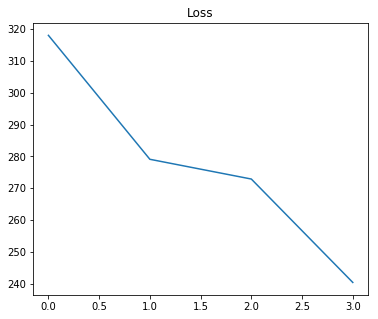

Test accuracy: 0.583


In [228]:
np.random.seed(123)

model = SpiralMLP(D=2, hidden_layer_sizes=[100, 100, 100, 100],
                  K=3, Z=ReLU(), learning_rate=1e-8, reg=1e-7)

model.fit(X_train, y_train, 1000, batch_size=100)

preds, Z = model.forward(X_test)
digit_preds = np.argmax(preds, axis=1)
test_acc = len(np.where(digit_preds == y_test)[0])/len(y_test)
print('Test accuracy: {:.3f}'.format(test_acc))

# Regression

In [269]:
X = np.random.randn(100, 2)
# y = x1**2 + x2**2 + random
y = (10*X[:,0]**2 + -5*X[:,1]**2 + np.random.randn(100,)).reshape(-1, 1)

epoch: 0 loss: 672.167685596247 performance_metric: -2.692834663455753
epoch: 1000 loss: 12.591146110743745 performance_metric: 0.9308252660656464
epoch: 2000 loss: 7.907255490347491 performance_metric: 0.9565581806544985
epoch: 3000 loss: 6.086855531138382 performance_metric: 0.9665593101565181
epoch: 4000 loss: 4.870259621105598 performance_metric: 0.9732431892602901


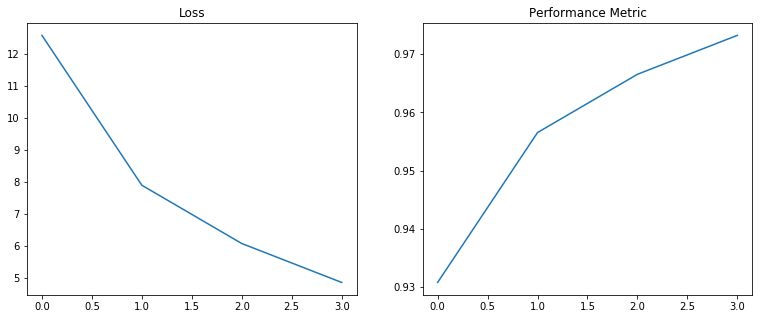

In [279]:
np.random.seed(123)

model = MLPRegressor(D=2, hidden_layer_sizes=[20, 20], K=1, Z=ReLU(), learning_rate=1e-6, reg=0)

model.fit(X, y, 5000)

preds, Z = model.predict(X)